In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import Imputer
from sklearn.experimental import enable_iterative_imputer  
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge
import matplotlib.pyplot as plt
from numpy.core.defchararray import add
from sklearn.preprocessing import MultiLabelBinarizer
import seaborn as sns # used for plot interactive graph.
from pylab import rcParams


In [2]:
np.random.seed(0) 
df = pd.read_csv("./googleplaystore.csv")

In [3]:
#Drop Duplicate along the App Column subset and dropna for columns with small percentage of missing value
df.drop_duplicates(subset='App',inplace = True)
df.dropna(subset=['Type', 'Content Rating','Current Ver','Android Ver'],inplace = True)

In [4]:
#Merge Category and Genre in one column
df_ex = ((((df.Category.str.lower()).str.split("_")).str.join(' ')).str.split("and")).str.join('&')
df_gx = ((df.Genres.str.lower()).str.split(";"))
listx=[]
for ex,gx in zip(df_ex,df_gx):
    if ex != gx[0]:
        if not (ex in gx[0]):
            gx.append(ex)
            if "educational" in gx:
                gx.remove("educational")
                gx.append("education")
    listx.append(np.unique(gx))
df["Genres"] = np.asarray(listx)

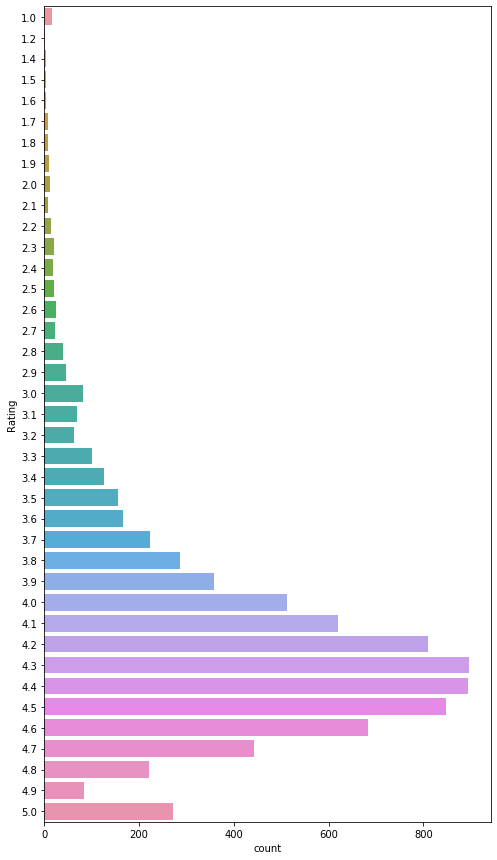

In [5]:
plt.figure(figsize=(8, 15))
sns.countplot(y='Rating',data=df )
plt.show()

/Users/mostafa/opt/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/Users/mostafa/opt/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


Text(0.5, 1.0, 'Distribution of Rating')

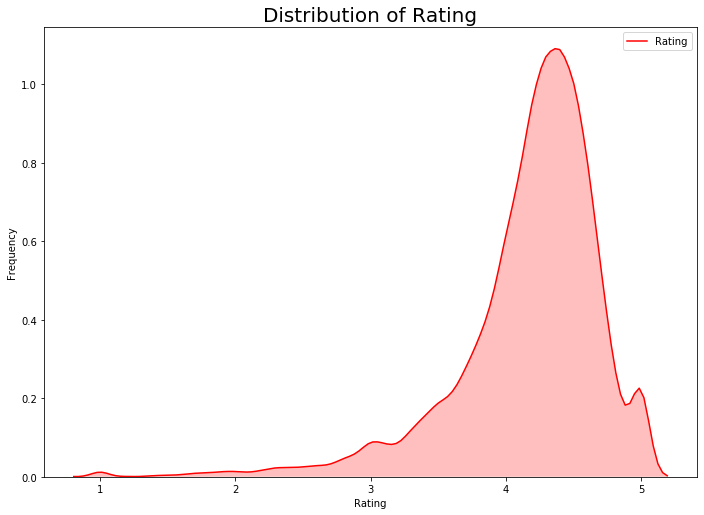

In [6]:
# rating distibution 
rcParams['figure.figsize'] = 11.7,8.27
g = sns.kdeplot(df.Rating, color="Red", shade = True)
g.set_xlabel("Rating")
g.set_ylabel("Frequency")
plt.title('Distribution of Rating',size = 20)

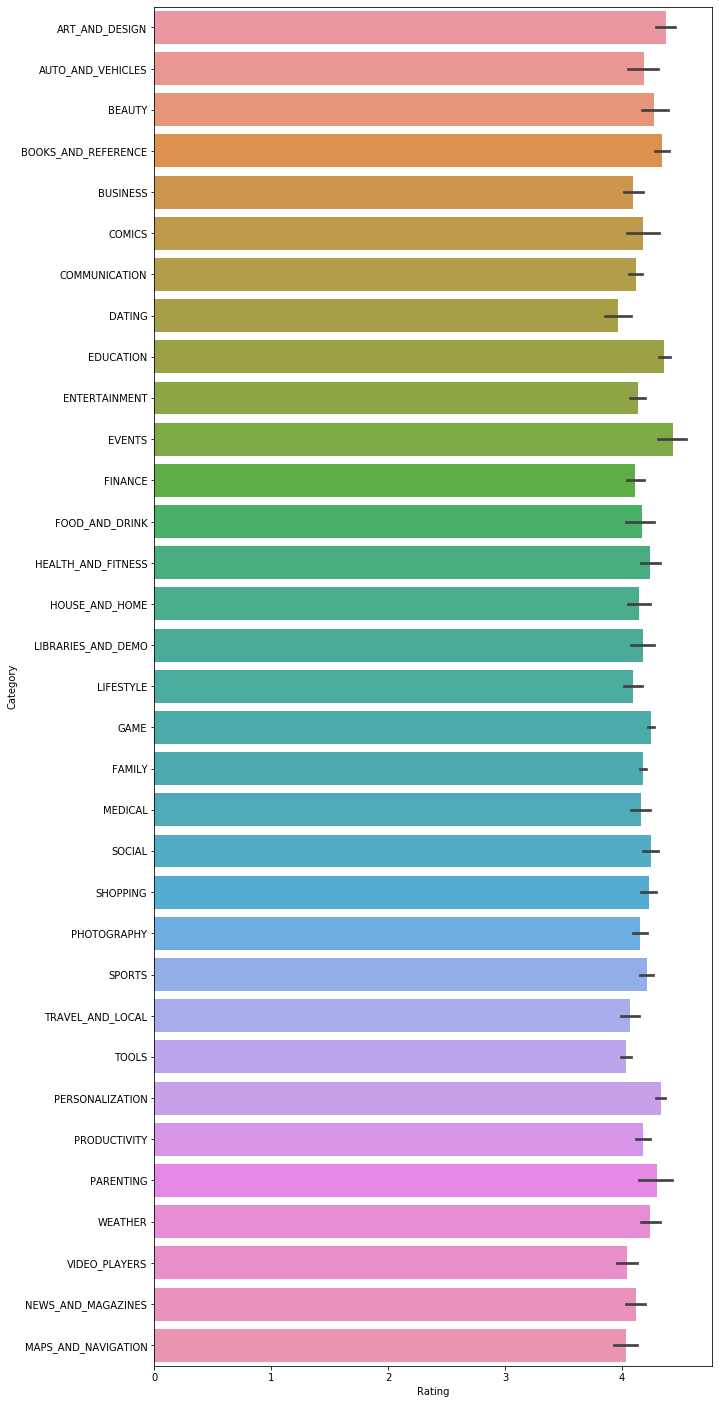

In [7]:
plt.figure(figsize=(10, 25))
sns.barplot(y='Category', x='Rating', data=df)
plt.show()

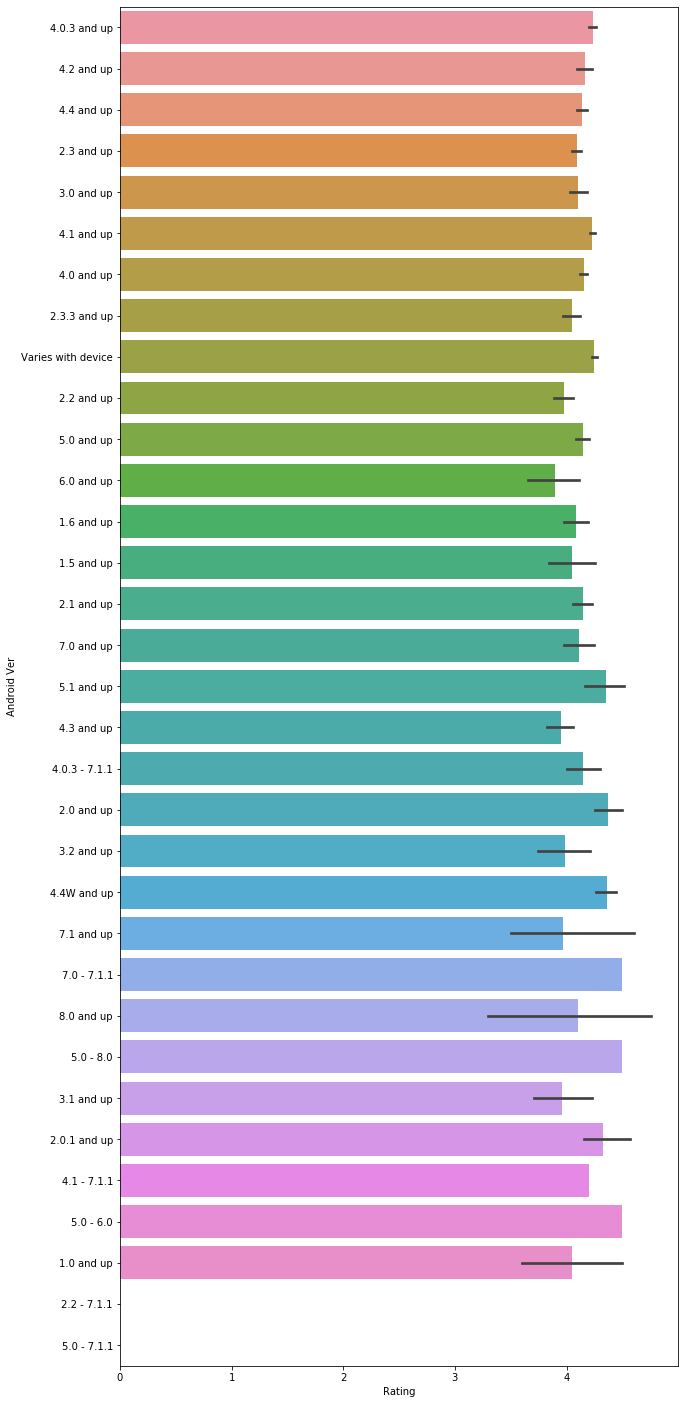

In [8]:
plt.figure(figsize=(10, 25))
sns.barplot(y='Android Ver', x='Rating', data=df)
plt.show()

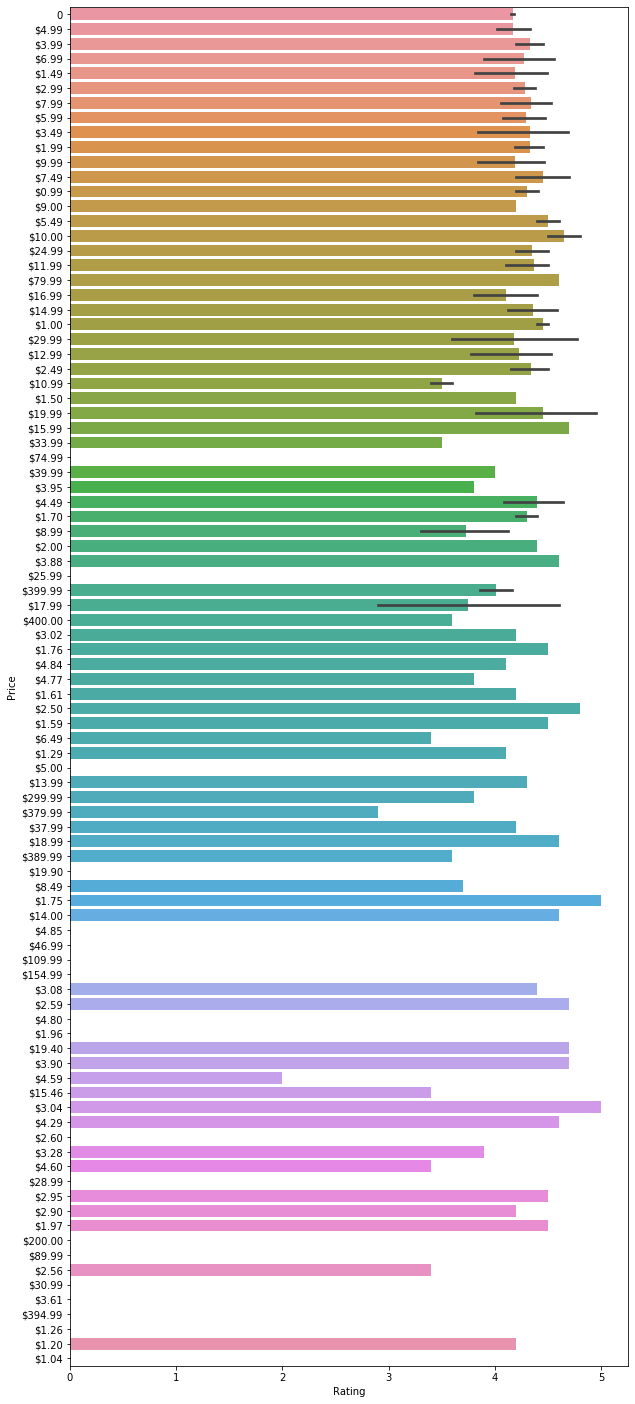

In [9]:
plt.figure(figsize=(10, 25))
sns.barplot(y='Price', x='Rating', data=df)
plt.show()

In [10]:
#Remove Column Category, Price, Last Updated,Current Ver, Android Ver for there irrelvance
df = df.drop(["Category","Price","Last Updated","Current Ver","Android Ver"],axis=1)

In [11]:
# Correct and convert size column to int
def change_size(size):
    if 'M' in size:
        x = size[:-1]
        x = float(x)*1000000
        return(x)
    elif 'k' == size[-1:]:
        x = size[:-1]
        x = float(x)*1000
        return(x)
    else:
        return None

df["Size"] = df["Size"].map(change_size)

df.Size.fillna(method = 'ffill', inplace = True)

In [12]:
# Convert installs to int
df['Installs'] = [int(i[:-1].replace(',','')) for i in df['Installs']]

In [13]:
#-----Remove unrated and label code the content rating
df = df.drop(df[df["Content Rating"]=="Unrated"].index)
RatingL = df['Content Rating'].unique()
RatingDict = {}
for i in range(len(RatingL)):
    RatingDict[RatingL[i]] = i
df['Content Rating'] = df['Content Rating'].map(RatingDict).astype(int)

In [14]:
#Clean Type
def type_clean(types):
    if "Free" in types:
        return 0
    else:
        return 1

df['Type'] = df['Type'].map(type_clean).astype(int)

In [15]:
#Convert Reviews to int
df['Reviews'] = df['Reviews'].astype(int)

In [16]:
#Convert non-null Ratings to float
df['Rating'] = df['Rating'].astype(float)

In [17]:
#Fix indexing
new_index = np.arange(0,len(df))
df = df.set_index(new_index)

In [18]:
#One Hot encode all genres
mlb = MultiLabelBinarizer()
df = df.join(pd.DataFrame(mlb.fit_transform(df.pop('Genres')),
                          columns=mlb.classes_,
                          index=df.index))

In [19]:
df.head()

,App,Rating,Reviews,Size,Installs,Type,Content Rating,action,action & adventure,adventure,...,simulation,social,sports,strategy,tools,travel & local,trivia,video players & editors,weather,word
0,Photo Editor & Candy Camera & Grid & ScrapBook,4.1,159,19000000.0,10000,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Coloring book moana,3.9,967,14000000.0,500000,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",4.7,87510,8700000.0,5000000,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Sketch - Draw & Paint,4.5,215644,25000000.0,50000000,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Pixel Draw - Number Art Coloring Book,4.3,967,2800000.0,100000,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


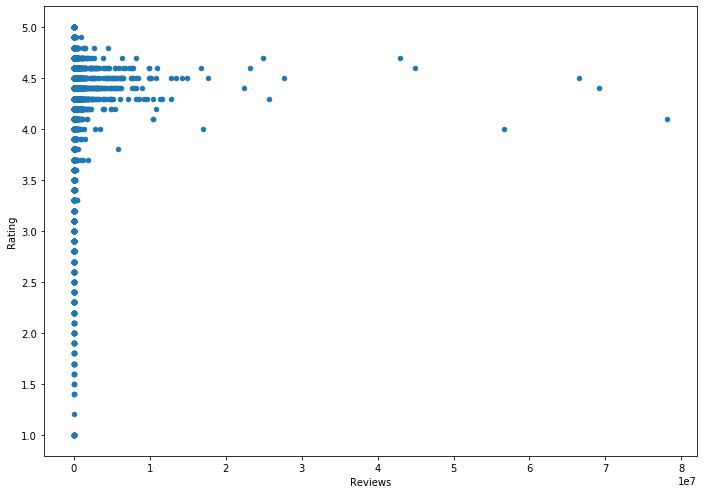

In [20]:
df.plot.scatter('Reviews','Rating')

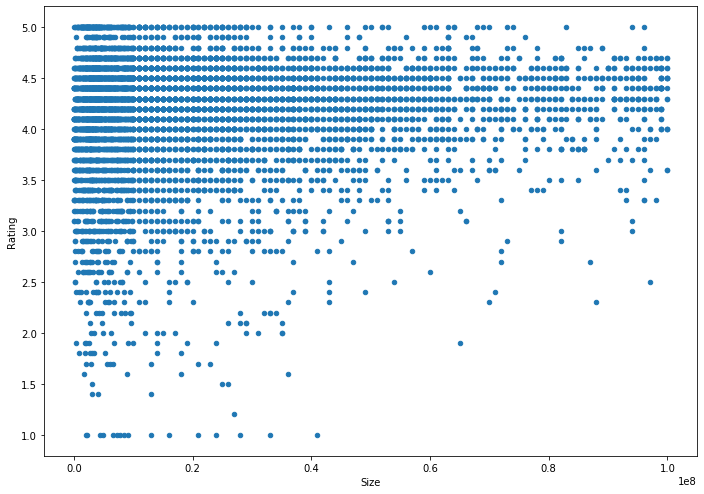

In [21]:
df.plot.scatter('Size','Rating')

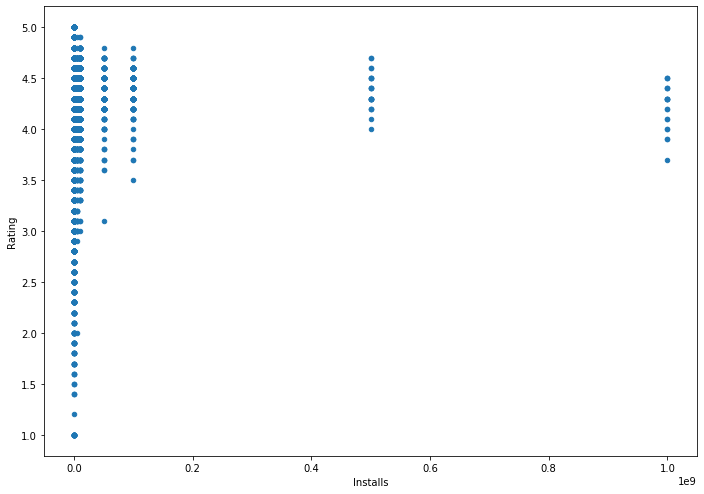

In [22]:
df.plot.scatter('Installs','Rating')

In [23]:
from sklearn.preprocessing import MinMaxScaler
df_scaled = df.copy().dropna()
scaler = MinMaxScaler(feature_range=(0, 1))
df_scaled[['Rating','Reviews']] = scaler.fit_transform(df_scaled[['Rating','Reviews']])
df_scaled[['Rating','Reviews']].head()

,Rating,Reviews
0,0.775,0.000002
1,0.725,0.000012
2,0.925,0.001120
3,0.875,0.002759
4,0.825,0.000012


In [24]:
df_scaled[['Rating','Size']] = scaler.fit_transform(df_scaled[['Rating','Size']])
df_scaled[['Rating','Size']].head()

,Rating,Size
0,0.775,0.189931
1,0.725,0.139927
2,0.925,0.086922
3,0.875,0.249936
4,0.825,0.027917


In [25]:
df_scaled[['Rating','Installs']] = scaler.fit_transform(df_scaled[['Rating','Installs']])
df_scaled[['Rating','Installs']].head()

,Rating,Installs
0,0.775,0.00001
1,0.725,0.00050
2,0.925,0.00500
3,0.875,0.05000
4,0.825,0.00010


In [26]:
X1_a = df_scaled['Rating'].values.reshape(-1,1) 
X2_a = df_scaled['Reviews'].values.reshape(-1,1)
# values method takes a column from pandas dataframe and makes it into an array of values --
# reshape arranges the extracted values in a numpy array with a shape we define --
# an array shape is the number of rows and columns in the array
# when we use parameter -1, it means we don't know the shape of the resulting array (e.g. X1)  -- 
# and numpy will figure it out based on length of array and whatever dimensions left
# in the case of reshape(-1, 1) we tell numpy to figure out the number of rows (parameter -1) but we have one column (parameter 1)

X_a = np.concatenate((X1_a,X2_a),axis=1) # define a NumPy array from the two arrays

In [27]:
X1_b = df_scaled['Rating'].values.reshape(-1,1) 
X2_b = df_scaled['Size'].values.reshape(-1,1)
# values method takes a column from pandas dataframe and makes it into an array of values --
# reshape arranges the extracted values in a numpy array with a shape we define --
# an array shape is the number of rows and columns in the array
# when we use parameter -1, it means we don't know the shape of the resulting array (e.g. X1)  -- 
# and numpy will figure it out based on length of array and whatever dimensions left
# in the case of reshape(-1, 1) we tell numpy to figure out the number of rows (parameter -1) but we have one column (parameter 1)

X_b = np.concatenate((X1_b,X2_b),axis=1) # define a NumPy array from the two arrays

In [28]:
X1_c = df_scaled['Rating'].values.reshape(-1,1) 
X2_c = df_scaled['Installs'].values.reshape(-1,1)
# values method takes a column from pandas dataframe and makes it into an array of values --
# reshape arranges the extracted values in a numpy array with a shape we define --
# an array shape is the number of rows and columns in the array
# when we use parameter -1, it means we don't know the shape of the resulting array (e.g. X1)  -- 
# and numpy will figure it out based on length of array and whatever dimensions left
# in the case of reshape(-1, 1) we tell numpy to figure out the number ofdf_scaled rows (parameter -1) but we have one column (parameter 1)

X_c = np.concatenate((X1_c,X2_c),axis=1) # define a NumPy array from the two arrays

In [29]:
# Import models
from pyod.models.hbos import HBOS # histogram-based outlier detection module
from pyod.models.cblof import CBLOF # cluster-based local outlier factor detection module
from pyod.models.knn import KNN # k nearest neighbors module
from pyod.models.lof import LOF # local outlier factor module


random_state = np.random.RandomState(42)
outliers_fraction = 0.05
# Define four outlier detection tools to be compared
# KNN uses the data point's distance to the farthest KNN for the outlier score
# Average KNN uses the average score for the data point's k nearest neighbors as the outlier score

# Create dictionary structure with model names and function calls
classifiers = {
#     'Histogram-base Outlier Detection (HBOS)': HBOS(contamination=outliers_fraction),    
#     'Local Outlier Factor (LOF)':LOF(contamination=outliers_fraction),
    #'Cluster-based Local Outlier Factor (CBLOF)':CBLOF(contamination=outliers_fraction,check_estimator=False, random_state=random_state),
    'K Nearest Neighbors (KNN)': KNN(contamination=outliers_fraction),
    #'Average KNN': KNN(method='mean',contamination=outliers_fraction)
}

In [30]:
df

,App,Rating,Reviews,Size,Installs,Type,Content Rating,action,action & adventure,adventure,...,simulation,social,sports,strategy,tools,travel & local,trivia,video players & editors,weather,word
0,Photo Editor & Candy Camera & Grid & ScrapBook,4.1,159,19000000.0,10000,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Coloring book moana,3.9,967,14000000.0,500000,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",4.7,87510,8700000.0,5000000,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Sketch - Draw & Paint,4.5,215644,25000000.0,50000000,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Pixel Draw - Number Art Coloring Book,4.3,967,2800000.0,100000,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9641,Sya9a Maroc - FR,4.5,38,53000000.0,5000,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9642,Fr. Mike Schmitz Audio Teachings,5.0,4,3600000.0,100,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9643,Parkinson Exercices FR,NaN,3,9500000.0,1000,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9644,The SCP Foundation DB fr nn5n,4.5,114,9500000.0,1000,0,3,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [31]:
import matplotlib.pyplot as plt
# For Box-Cox Normalization
from scipy import stats



# # Define a grid with equally spaced cells using NumPy for visualization
# xx , yy = np.meshgrid(np.linspace(0,1 , 200), np.linspace(0, 1, 200))

# for iterator, call each model name and model function from the dictionary
for i, (clf_name, clf) in enumerate(classifiers.items()):
    
    # Fit the model in current iteration to data X which contains the two scaled attributes
    clf.fit(X_a) 
    
    # Predict raw anomaly score for entire dataset X using decision function
    # Decision function is a conceptual separator between two classes in the dataset, in this case "normal" versus "outlier"
    scores_pred = clf.decision_function(X_a) * -1 
        
    # Label each data point in X as outlier or inlier: label = 1 is for outlier and label = 0 is for inlier
    y_pred = clf.predict(X_a)
    

y_pred = np.array(y_pred)    
outlier_index = np.asarray(np.where(y_pred == 1)).flatten()
# outlier_index.reshape((1, -1))

for i in range(len(outlier_index)):
    print(outlier_index[i])

77
131
144
190
263
286
287
289
291
292
293
296
298
302
307
314
316
317
321
322
329
336
337
344
347
348
350
352
378
522
534
640
650
651
659
674
678
692
721
783
786
801
815
887
890
911
963
967
974
982
993
1023
1060
1061
1273
1274
1275
1279
1280
1281
1282
1283
1285
1286
1287
1288
1290
1295
1297
1300
1302
1303
1305
1309
1310
1313
1314
1315
1317
1318
1319
1320
1321
1322
1323
1326
1327
1328
1331
1332
1334
1336
1337
1342
1343
1344
1352
1359
1362
1363
1368
1375
1383
1393
1395
1401
1415
1416
1419
1428
1432
1435
1440
1441
1442
1443
1445
1449
1451
1459
1467
1472
1474
1490
1563
1589
1661
1870
1871
1872
1874
1876
1878
1880
1897
1913
1917
1918
1924
1937
1939
1940
1950
1955
1957
1960
1979
1993
2010
2059
2060
2065
2067
2084
2086
2100
2111
2114
2117
2123
2137
2145
2149
2158
2159
2162
2163
2166
2182
2272
2283
2288
2291
2297
2310
2375
2376
2380
2394
2403
2414
2427
2436
2457
2466
2480
2485
2491
2497
2502
2511
2519
2522
2560
2578
2582
2584
2585
2586
2589
2595
2601
2605
2617
2620
2625
2627
2655
2725
2727
27

In [32]:
for i, (clf_name, clf) in enumerate(classifiers.items()):
    
    # Fit the model in current iteration to data X which contains the two scaled attributes
    clf.fit(X_b) 
    
    # Predict raw anomaly score for entire dataset X using decision function
    # Decision function is a conceptual separator between two classes in the dataset, in this case "normal" versus "outlier"
    scores_pred = clf.decision_function(X_b) * -1 
        
    # Label each data point in X as outlier or inlier: label = 1 is for outlier and label = 0 is for inlier
    y_pred = clf.predict(X_b)
    

y_pred = np.array(y_pred)    
outlier_index1 = np.asarray(np.where(y_pred == 1)).flatten()
# outlier_index1.reshape((1, -1))

for i in range(len(outlier_index1)):
    print(outlier_index1[i])

227
280
432
434
458
496
501
659
697
763
783
784
898
902
970
1145
1201
1275
1313
1362
1384
1395
1408
1543
1552
1599
1626
1634
1636
1680
1712
1718
1734
1767
1804
1824
1825
1835
1838
1930
1997
2127
2227
2228
2258
2308
2309
2326
2791
2806
2819
2918
2962
2984
2993
3005
3032
3035
3039
3089
3121
3146
3150
3168
3226
3273
3289
3302
3319
3351
3400
3411
3417
3426
3457
3462
3465
3491
3492
3504
3562
3580
3582
3609
3610
3630
3674
3687
3697
3700
3701
3703
3762
3766
3767
3773
3786
3795
3891
3898
3909
3933
3941
3945
3956
3961
4009
4012
4014
4035
4045
4174
4212
4219
4230
4231
4232
4233
4264
4270
4276
4277
4284
4318
4344
4362
4364
4388
4400
4420
4422
4440
4473
4548
4552
4553
4574
4579
4601
4626
4717
4729
4742
4852
4862
4867
4904
4958
4982
5013
5025
5039
5051
5054
5062
5077
5078
5080
5090
5104
5115
5127
5144
5208
5240
5267
5285
5342
5367
5380
5420
5479
5482
5490
5539
5560
5570
5588
5590
5591
5596
5602
5607
5641
5646
5664
5679
5721
5758
5764
5766
5769
5774
5789
5807
5840
5984
5995
5997
6059
6068
6089
6105


In [33]:
for i, (clf_name, clf) in enumerate(classifiers.items()):
    
    # Fit the model in current iteration to data X which contains the two scaled attributes
    clf.fit(X_c) 
    
    # Predict raw anomaly score for entire dataset X using decision function
    # Decision function is a conceptual separator between two classes in the dataset, in this case "normal" versus "outlier"
    scores_pred = clf.decision_function(X_c) * -1 
        
    # Label each data point in X as outlier or inlier: label = 1 is for outlier and label = 0 is for inlier
    y_pred = clf.predict(X_c)
    

y_pred = np.array(y_pred)    
outlier_index2 = np.asarray(np.where(y_pred == 1)).flatten()
# outlier_index2.reshape((1, -1))

for i in range(len(outlier_index2)):
    print(outlier_index2[i])
    
print(type(outlier_index2[1]))


68
144
168
214
263
286
287
292
322
329
336
344
432
434
493
522
654
659
965
967
1038
1060
1182
1206
1274
1275
1328
1343
1680
1734
1767
1804
1817
1835
1864
1870
1871
1876
1880
2059
2060
2075
2283
2297
2307
2314
2375
2376
2387
2390
2394
2400
2403
2404
2406
2582
2586
2592
2605
2608
2615
2621
2624
2683
2769
2771
2786
2802
2832
2844
2851
2962
2966
2984
2989
3011
3034
3035
3064
3130
3143
3147
3161
3172
3198
3201
3273
3325
3411
3412
3417
3426
3437
3438
3488
3496
3501
3562
3576
3609
3610
3630
3664
3697
3700
3765
3766
3767
3786
3832
3834
3850
3891
3893
3898
3950
3961
3983
3994
3996
3998
4009
4014
4180
4200
4212
4233
4312
4364
4400
4402
4422
4448
4473
4518
4548
4552
4553
4574
4609
4614
4626
4638
4669
4686
4723
4727
4729
4740
4742
4758
4779
4811
4812
4840
4857
4862
4889
4899
4929
4999
5013
5062
5077
5078
5080
5104
5115
5155
5171
5173
5194
5197
5208
5221
5235
5240
5252
5256
5264
5265
5285
5342
5366
5373
5391
5404
5415
5420
5431
5486
5490
5494
5564
5565
5591
5630
5640
5646
5665
5667
5674
5681
5766
5

In [34]:
concat_index = np.concatenate((outlier_index, outlier_index1, outlier_index2))
len(concat_index)

984

In [35]:
concat_index = np.unique(concat_index)
len(concat_index)

816

In [36]:
len(df)

9646

In [37]:
df = df.drop(concat_index)

In [38]:
#Fix indexing
new_index = np.arange(0,len(df))
df = df.set_index(new_index)

In [39]:
df

,App,Rating,Reviews,Size,Installs,Type,Content Rating,action,action & adventure,adventure,...,simulation,social,sports,strategy,tools,travel & local,trivia,video players & editors,weather,word
0,Photo Editor & Candy Camera & Grid & ScrapBook,4.1,159,19000000.0,10000,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Coloring book moana,3.9,967,14000000.0,500000,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",4.7,87510,8700000.0,5000000,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Sketch - Draw & Paint,4.5,215644,25000000.0,50000000,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Pixel Draw - Number Art Coloring Book,4.3,967,2800000.0,100000,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8825,Sya9a Maroc - FR,4.5,38,53000000.0,5000,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8826,Fr. Mike Schmitz Audio Teachings,5.0,4,3600000.0,100,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8827,Parkinson Exercices FR,NaN,3,9500000.0,1000,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8828,The SCP Foundation DB fr nn5n,4.5,114,9500000.0,1000,0,3,0,0,0,...,0,0,0,0,0,0,0,0,0,0


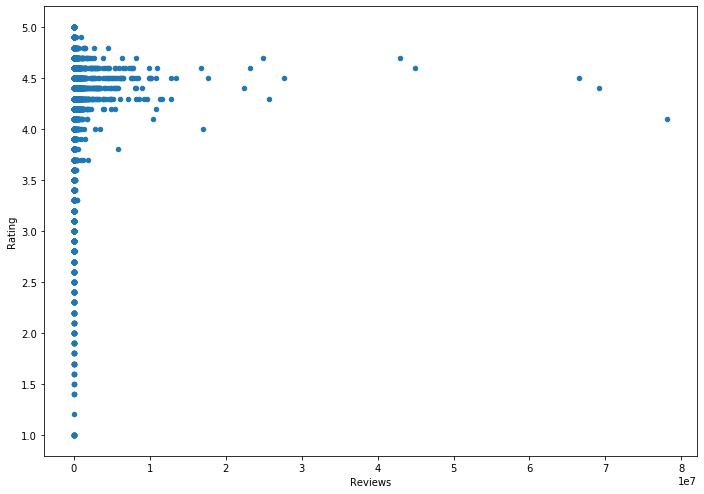

In [40]:
df.plot.scatter('Reviews','Rating')

In [41]:
#Checking for any missing values
missing_values_count = df.isnull().sum()
print(missing_values_count)
indices_of_missing = df['Rating'].isnull()
print(indices_of_missing.sum())

App                           0
Rating                     1347
Reviews                       0
Size                          0
Installs                      0
                           ... 
travel & local                0
trivia                        0
video players & editors       0
weather                       0
word                          0
Length: 61, dtype: int64
1347


In [42]:
#Impute the missing nans in Rating using multivariate imputation
reg_imputer = IterativeImputer(BayesianRidge(), max_iter=5, random_state=0)
subset_data = df.loc[:, 'Rating':'word']
imputed_subset = pd.DataFrame(reg_imputer.fit_transform(subset_data), columns=subset_data.columns)
df.loc[:,'Rating':'word'] = imputed_subset.loc[:,'Rating':'word']



In [43]:
#Checking for any missing values
missing_values_count = df.isnull().sum()
missing_values_count

App                        0
Rating                     0
Reviews                    0
Size                       0
Installs                   0
                          ..
travel & local             0
trivia                     0
video players & editors    0
weather                    0
word                       0
Length: 61, dtype: int64

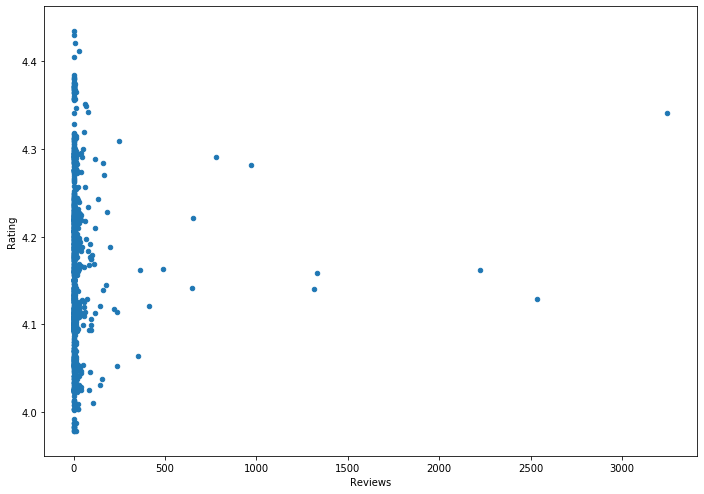

In [44]:
#showing the distribution of the ESTIMATED values only against reviews
df[indices_of_missing].plot.scatter('Reviews','Rating')

Text(0.5, 1.0, 'Rating VS Reveiws')

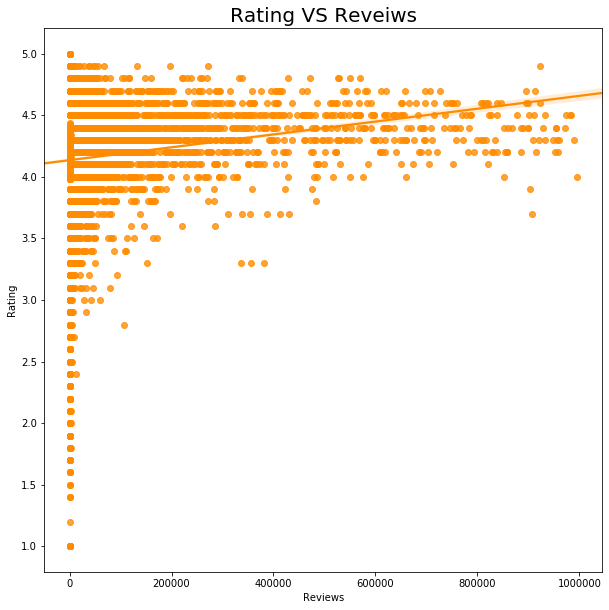

In [45]:
#showing the distribution fot rating against reviews for reviews less than 1000000
plt.figure(figsize = (10,10))
sns.regplot(x="Reviews", y="Rating", color = 'darkorange',data=df[df['Reviews']<1000000]);
plt.title('Rating VS Reveiws',size = 20)